In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("slavkoprytula/aquarium-data-cots")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/slavkoprytula/aquarium-data-cots/versions/1


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import glob
import os
import json
from PIL import Image
import xml.etree.ElementTree as ET
import pprint
pp = pprint.PrettyPrinter(indent=4)
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import torchvision.ops as ops
from torch.utils.data import distributed, RandomSampler, SequentialSampler
import random
import cv2
from collections import Counter

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
TRAIN_PATH = os.path.join(path, "aquarium_pretrain/train")
VAL_PATH = os.path.join(path, "aquarium_pretrain/valid")
TEST_PATH = os.path.join(path, "aquarium_pretrain/test")

TRAIN_LABELS = TRAIN_PATH + "/labels"
VAL_LABELS = VAL_PATH + "/labels"
TEST_LABELS = TEST_PATH + "/labels"

TRAIN_IMAGES = TRAIN_PATH + "/images"
VAL_IMAGES = VAL_PATH + "/images"
TEST_IMAGES = TEST_PATH + "/images"

In [8]:
classes = ["fish", "jellyfish", "penguin", "puffin", "shark", "starfish", "stingray"]
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print("Index to Label Mapping:", Idx2Label)
print("Label to Index Mapping:", Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


In [9]:
def describe_dataset(image_path, label_path):
    images = os.listdir(image_path)
    labels = os.listdir(label_path)
    print(f"Number of images: {len(images)}")
    print(f"Number of labels: {len(labels)}")

describe_dataset(TRAIN_IMAGES, TRAIN_LABELS)

Number of images: 448
Number of labels: 448


In [10]:
def class_distribution(label_path):
    label_counts = Counter()
    for label_file in os.listdir(label_path):
        with open(os.path.join(label_path, label_file)) as f:
            for line in f.readlines():
                class_id = int(line.split()[0])  # Assuming YOLO format
                label_counts[class_id] += 1
    return label_counts

train_distribution = class_distribution(TRAIN_LABELS)
print("Class Distribution:", train_distribution)

Class Distribution: Counter({0: 1961, 1: 385, 2: 330, 4: 259, 3: 175, 6: 136, 5: 78})


In [11]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.CLAHE(p=0.2),
    A.Resize(640, 640),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [13]:
class UnderwaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, augmentation=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = os.listdir(image_dir)
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace('.jpg', '.txt'))

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load labels (YOLO format: class_id x_center y_center width height)
        boxes = []
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x, y, w, h = map(float, line.split())
                boxes.append([class_id, x, y, w, h])

        if self.augmentation:
            augmented = self.augmentation(image=image, bboxes=boxes)
            image, boxes = augmented['image'], augmented['bboxes']

        if self.transform:
            image = self.transform(image)

        return image, boxes

In [14]:
pip install ultralytics

In [15]:
# Verify the file path using Kaggle UI or run the following command
!ls /kaggle/input/aquarium-data-cots/aquarium_pretrain/
# Update the data variable to the correct path of the data.yaml file, if needed:
data = "/kaggle/input/aquarium-data-cots/aquarium_pretrain/data.yaml"  # Update to the correct path

ls: cannot access '/kaggle/input/aquarium-data-cots/aquarium_pretrain/': No such file or directory


In [16]:
from ultralytics import YOLO

model = YOLO("yolov5s.pt")

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [17]:
data = os.path.join(path, "aquarium_pretrain/data.yaml")

print("Path to data.yaml:", data)

Path to data.yaml: /root/.cache/kagglehub/datasets/slavkoprytula/aquarium-data-cots/versions/1/aquarium_pretrain/data.yaml


In [19]:
image_path = os.path.join(path, "aquarium_pretrain/test/images/img_11.jpg")

print("Path to img_11.jpg:", image_path)

Path to img_11.jpg: /root/.cache/kagglehub/datasets/slavkoprytula/aquarium-data-cots/versions/1/aquarium_pretrain/test/images/img_11.jpg


In [21]:
# prompt: now train the model and predict using it

# Train the model
results = model.train(data=data, epochs=10) # You can adjust the number of epochs

# Make predictions on an image (replace with your image path)

# Optionally, you can save the trained model.
# model.export(format="onnx") # Export the model to ONNX format (if needed).


Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=/root/.cache/kagglehub/datasets/slavkoprytula/aquarium-data-cots/versions/1/aquarium_pretrain/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False

train: Scanning /root/.cache/kagglehub/datasets/slavkoprytula/aquarium-data-cots/versions/1/aquarium_pretrain/train/labels.cache... 448 images, 1 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /root/.cache/kagglehub/datasets/slavkoprytula/aquarium-data-cots/versions/1/aquarium_pretrain/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]


Plotting labels to runs/detect/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train222
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.48G      1.317      1.145      1.151        130        640: 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        127        909      0.784      0.614        0.7      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.32G      1.256      1.077      1.107        113        640: 100%|██████████| 28/28 [00:09<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        127        909      0.783      0.579      0.663      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.32G      1.243      1.054      1.094        111        640: 100%|██████████| 28/28 [00:09<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        127        909      0.729      0.593      0.675      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.25G      1.202      1.001      1.085         93        640: 100%|██████████| 28/28 [00:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        127        909      0.764      0.553      0.662      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       4.3G      1.189      1.018      1.084        102        640: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        127        909      0.723      0.622      0.672      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.25G      1.206     0.9895      1.085        130        640: 100%|██████████| 28/28 [00:09<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        127        909      0.803      0.555      0.658      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.33G      1.216     0.9685      1.079        162        640: 100%|██████████| 28/28 [00:10<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.703      0.616      0.669      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.07G      1.221     0.9687      1.085         82        640: 100%|██████████| 28/28 [00:09<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all        127        909      0.771      0.601      0.685      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.28G      1.232     0.9632      1.083        145        640: 100%|██████████| 28/28 [00:09<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        127        909      0.758      0.608      0.706      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.27G      1.249     0.9551      1.094        131        640: 100%|██████████| 28/28 [00:09<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        127        909      0.777       0.62      0.715      0.419



10 epochs completed in 0.035 hours.
Optimizer stripped from runs/detect/train222/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/train222/weights/best.pt, 18.5MB

Validating runs/detect/train222/weights/best.pt...
Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 193 layers, 9,114,245 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


                   all        127        909      0.776       0.62      0.715      0.419
                  fish         63        459      0.834      0.669      0.767       0.43
             jellyfish          9        155      0.829      0.904      0.919       0.51
               penguin         17        104      0.728      0.644      0.692      0.314
                puffin         15         74      0.692      0.365      0.514      0.241
                 shark         28         57      0.794      0.509      0.676      0.425
              starfish         17         27      0.819      0.556      0.694       0.48
              stingray         23         33      0.734      0.697      0.742      0.533
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train222


In [27]:
# prompt: do  prediction for this path /content/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg

import torch
from ultralytics import YOLO

# Load a pretrained YOLO model (ensure you have the correct weights file)
model = YOLO("yolov5s.pt")  # Or your trained model weights

# Provide the image path for prediction
image_path = "/content/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg"

# Perform the prediction
results = model(image_path)

# Print or process the results
print(results)

# You can access various information from the results:
# e.g., bounding boxes, class labels, confidence scores
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Class probabilities for classification outputs
boxes
    # ... process other outputs as needed ...


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


image 1/1 /content/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg: 640x480 2 bears, 43.2ms
Speed: 3.5ms preprocess, 43.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suit

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([21., 21.], device='cuda:0')
conf: tensor([0.2920, 0.2579], device='cuda:0')
data: tensor([[3.0744e+02, 4.7327e+02, 4.5522e+02, 5.5169e+02, 2.9203e-01, 2.1000e+01],
        [3.8332e+02, 3.0422e+02, 4.5324e+02, 4.0068e+02, 2.5787e-01, 2.1000e+01]], device='cuda:0')
id: None
is_track: False
orig_shape: (1024, 768)
shape: torch.Size([2, 6])
xywh: tensor([[381.3312, 512.4796, 147.7797,  78.4283],
        [418.2775, 352.4512,  69.9229,  96.4600]], device='cuda:0')
xywhn: tensor([[0.4965, 0.5005, 0.1924, 0.0766],
        [0.5446, 0.3442, 0.0910, 0.0942]], device='cuda:0')
xyxy: tensor([[307.4414, 473.2654, 455.2211, 551.6938],
        [383.3161, 304.2212, 453.2389, 400.6812]], device='cuda:0')
xyxyn: tensor([[0.4003, 0.4622, 0.5927, 0.5388],
        [0.4991, 0.2971, 0.5902, 0.3913]], device='cuda:0')

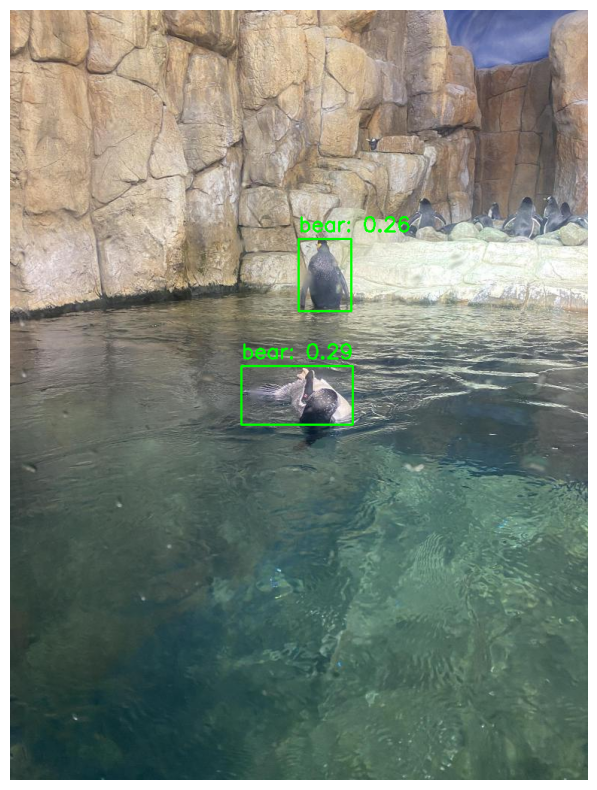

In [33]:
import matplotlib.pyplot as plt
import cv2

# Assuming 'results' from your YOLO prediction is available

# Load the image
image_path = "/content/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Access the bounding boxes and labels from the results
for result in results:
    boxes = result.boxes
    for box in boxes:
        xyxy = box.xyxy[0].cpu().numpy() # get bounding box coordinates
        confidence = box.conf[0].cpu().numpy() # get confidence score
        class_id = int(box.cls[0].cpu().numpy()) # get class id

        # Get class label from YOLOv5's model.names
        label = model.names[class_id]


        x1, y1, x2, y2 = map(int, xyxy)  # Convert to integers
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Display the label and confidence on the image
        label_text = f"{label}: {confidence:.2f}"
        cv2.putText(img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding boxes and labels
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()